In [2]:
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import elevation
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.mask import mask
from rasterio import windows
from rasterio import warp
from rasterio.warp import calculate_default_transform, reproject
from rasterio import MemoryFile
from rasterio.enums import Resampling


# Georeferencing Geologic map
Scanned maps need to be georeferenced if they are going to be used with geographic data such as DEM. You can find georeferencing control points(GCP) mapping pixcel coordinates to geographic coordinates under data/raw/KR2002_GE.jpg.points. GCPs are easily identified in this map since it has lat/lng grids. With scanned image and GCP, you can georeference the scanned image to geotiff using GDAL or QGIS. The coordinate reference system (CRS) of this map will be epsg:4236 since we used lat/lng coordinates. 

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8594, 'height': 8518, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0012584521604607887, 0.0, 122.158092089,
       0.0, -0.0012584521604836812, 43.385469408)}


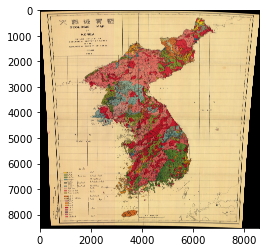

In [33]:
gmap = rasterio.open("../data/processed/geology_map/KR2002_GE_4326_compressed.tif")
print(gmap.meta)
show(gmap.read())

In [3]:
gmap.bounds

BoundingBox(left=122.158092089, bottom=32.665973905, right=132.973229956, top=43.385469408)

## Reproject
We are going to reproject this raster to epsg:5178 to make the raster similar to the original form.

In [17]:
# function for reprojection
def reprojection(src_path, dst_path, dst_crs, zscale=1):
    with rasterio.open(src_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'nodata': 0,
            'dtypes': rasterio.uint16,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                if zscale == -1:
                    rescaled = np.interp(
                        src.read(i), 
                        (src.read(i).min(), src.read(i).max()), 
                        (1, 2**15-1))
                else:
                    rescaled = src.read(i) * zscale
                reproject(
                    source=rescaled,
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.cubic)

In [5]:
dst_crs = 'EPSG:5178'
reprojection(
    "../data/processed/geology_map/KR2002_GE_4326_compressed.tif", 
    "../data/processed/geology_map/KR2002_GE_5178.tif", 
    dst_crs)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 8076, 'height': 9582, 'count': 3, 'crs': CRS.from_epsg(5178), 'transform': Affine(125.64751935433051, 0.0, 499000.1017706497,
       0.0, -125.64751935433051, 2612082.8797568628)}


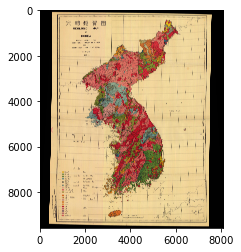

In [3]:
gmap_5178 = rasterio.open("../data/processed/geology_map/KR2002_GE_5178.tif")
print(gmap_5178.meta)
show(gmap_5178.read())

In [4]:
gmap_5178.bounds

BoundingBox(left=499000.1017706497, bottom=1408128.349303668, right=1513729.468076223, top=2612082.8797568628)

In [11]:
# write world file
with open("../data/processed/geology_map/reprojection.wld", "w") as f:
    t = gmap_5178.profile['transform']
    f.write(f"{t[0]}\n{t[3]}\n{t[1]}\n{t[4]}\n{t[2]}\n{t[5]}")

# Get Elevation Data
We are going to use NASA's SRTM 30m data for elevation data. The original geology map's bound is 
(122, 32, 133, 44)

In [56]:
dir_srtm = "/media/yongha/data/geodata/srtm"
elevation.clip(
    bounds=(122, 32, 133, 44), 
    product='SRTM1',
    output=os.path.join(dir_srtm, "korea_srtm.tif"))


RuntimeError: Too many tiles: 132. Please consult the providers' websites for how to bulk download tiles.

Elevation module fails when you are going to do bulk donwload. In that case, use srtm download in QGIS and merge yourself.

# Mosaic

In [59]:
dir_srtm = "/media/yongha/data/geodata/srtm"
srtms = glob.glob(dir_srtm + "/*.hgt")
len(srtms)

92

In [63]:
def mosaic(list_hgt):
    srcs = []
    for fp in list_hgt:
       src = rasterio.open(fp)
       srcs.append(src)
    raster_mosaic, mosaic_transform = merge(srcs, nodata=0)
    profile_mosaic = src.profile
    profile_mosaic.update({
        "driver": "GTiff",
        "height": raster_mosaic.shape[1],
        "width": raster_mosaic.shape[2],
        "transform": mosaic_transform
    })
    return raster_mosaic, profile_mosaic

In [66]:
raster_mosaic, profile_mosaic = mosaic(srtms)

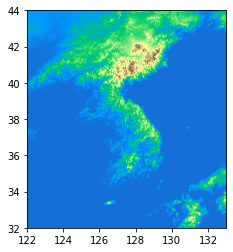

In [65]:
show(raster_mosaic, cmap='terrain', transform=profile_mosaic['transform'])

In [67]:
with rasterio.open("../data/processed/dem/dem_4236.tif", "w", **profile_mosaic) as dest:
    dest.write(raster_mosaic)

## Reprojection
match the projection to the scanned map ('EPSG:5178').

In [20]:
dst_crs = 'EPSG:5178'
reprojection(
    "../data/processed/dem/dem_4236.tif", 
    "../data/processed/dem/dem_5178.tif", 
    dst_crs,
    zscale=-1
)

## Crop
See https://github.com/gonzmg88/gonzmg88.github.io/blob/master/blog/notebooks/rasterio_conversions.ipynb for more details on cropping

In [21]:
def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    geom = {
        "type":"Polygon",
        "coordinates":[[
            (bbox[0],bbox[1]),
            (bbox[2],bbox[1]),
            (bbox[2],bbox[3]),
            (bbox[0],bbox[3]),
            (bbox[0],bbox[1])
        ]]}
    
    return geom

In [22]:
def crop(raster, profile, bounds):
    crop_frame = generate_polygon(bounds)
    raster_crop, crop_transform = mask(raster, shapes=[crop_frame], crop=True)
    profile_crop = profile
    profile_crop.update({
        "height": raster_crop.shape[1],
        "width": raster_crop.shape[2],
        "transform": crop_transform})
    return raster_crop, profile_crop

In [23]:
crop_frame = generate_polygon(gmap_5178.bounds)
crop_frame

{'type': 'Polygon',
 'coordinates': [[(499000.1017706497, 1408128.349303668),
   (1513729.468076223, 1408128.349303668),
   (1513729.468076223, 2612082.8797568628),
   (499000.1017706497, 2612082.8797568628),
   (499000.1017706497, 1408128.349303668)]]}

In [24]:
dem = rasterio.open("../data/processed/dem/dem_5178.tif")
# out_img, out_transform = mask(dataset=data, shapes=[gmap_5178.bounds], crop=True)

In [25]:
dem_crop, profile_crop = crop(dem, dem.profile, gmap_5178.bounds)

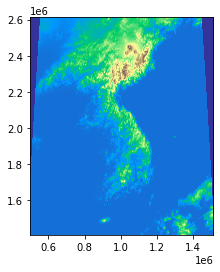

In [26]:
show(dem_crop, cmap='terrain',  transform=profile_crop['transform'])

In [27]:
with rasterio.open("../data/processed/dem/dem_5178_crop.tif", "w", **profile_crop) as dest:
    dest.write(dem_crop)

## Resampling
We need to make this dem to the same size with the geologic map.


In [28]:
def resample(raster, profile, height, width):
    
    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(raster)
        with memfile.open() as dataset:  # Reopen as DatasetReader
            raster_resize = dataset.read(
                out_shape=(
                    profile['count'],
                    height,
                    width
                ),
                resampling=Resampling.cubic
            )
        
    profile_resize = profile
    transform_resize = profile['transform'] * profile['transform'].scale(
        (dataset.width / raster_resize.shape[-1]),
        (dataset.height / raster_resize.shape[-2])
    )
    profile_resize.update({
        "height": height,
        "width": width,
        "transform": transform_resize
    })
    return raster_resize, profile_resize

In [29]:
print(gmap_5178.height)
print(gmap_5178.width)

9582
8076


In [30]:
dem_resize, profile_resize = resample(dem_crop, profile_crop, gmap_5178.height, gmap_5178.width)

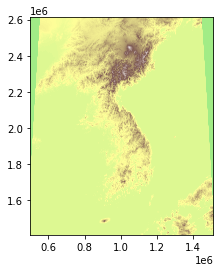

In [31]:
show(dem_resize, cmap='terrain', transform=profile_resize['transform'])

In [32]:
with rasterio.open("../data/processed/dem/dem_5178_crop_resize.tif", "w", **profile_resize) as dest:
    dest.write(dem_resize)